In [68]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from scipy.interpolate import interp1d
from tqdm import tqdm

linalg = np.linalg

In [80]:
def generate_pearson_data(corr, num_samples):
    """
    Given a correlation coefficient, generate X, Y samples. Taken from:
    https://stackoverflow.com/questions/16024677/generate-correlated-data-in-python-3-3
    :float corr: The pearson correlation coefficient of the data to sample
    :int num_samples: number of samples to generate
    """

    num_variables = 2
    cov = [[1.0, corr], [corr, 1.0]]

    L = linalg.cholesky(cov)

    uncorrelated = np.random.standard_normal((num_variables, num_samples))
    correlated = np.dot(L, uncorrelated)
    X, Y = correlated

    return X, Y

In [81]:
def n_to_perc_thresh(n):
    """
    Convert n to a percentile threshold for whole number n
    """
    
    if n==0:
        perc_thresh = 50
    else:
        perc_thresh = 10**(2-n)
        
    return perc_thresh

# How many assays does it take to capture top n predictions?

In [84]:
def capture_predictions(ex_vals, pred_vals, ex_capture):
    """
    Given a vector of experimental values, a vector of predicted values,
    and a threshold number of top experimental values to capture, return
    the ranks of the predicted values needed to capture all experimental values.
    :list ex_vals: list of numerical experimental values
    :list pred_vals: list of numerical predicted vlaues
    :int ex_capture: Number of top experimental values to capture
    """
    
    rank_ex = stats.rankdata(ex_vals)
    rank_pred = stats.rankdata(pred_vals)
    
    capt_ix = [t <= ex_capture for t in rank_ex]
    
    captured_preds = [int(x) for x in rank_pred[capt_ix]]
    
    return captured_preds

In [88]:
def to_capture_top_n(ex_vals, pred_vals, ex_capture):
    """
    Given a vector of experimental values, a vector of predicted values,
    and a threshold number of top experimental values to capture, return
    the number of predicted values required to capture the top experimental values.
    :list ex_vals: list of numerical experimental values
    :list pred_vals: list of numerical predicted vlaues
    :int ex_capture: Number of top experimental values to capture
    """
    
    captured_preds = capture_predictions(ex_vals, pred_vals, ex_capture)
        
    return np.max(captured_preds)

In [141]:
def n_9s_performance(ex_capture, lib_size, r2, trials=10000, n=3, percent=True, verbose=True):
    """
    Given a library and a desire to capture the top experimental values using 
    a model with a known R^2 ... how many compounds can we discard with n 9s confidence?
    :int ex_capture: Number of top experimental values to capture
    :int lib_size: Size of the compound list or library
    :num r2: The R^2 of the model in question
    :int trials: Number of trials to run - default 10k
    :int n: Number of 9's of confidence - default 3 9s, i.e. 99.9% 
    :bool percent: if True, present results as a percentage
    :bool verbose: if True, print a verbose description of results
    """
    
    cor = np.sqrt(r2)
    perc_thresh = n_to_perc_thresh(n)
    top_n_savings = []
    
    #Comment out this row if you don't want consistent results! 
    np.random.seed(1)
    
    for _ in tqdm(range(0, trials)):
        
        ex_vals, pred_vals = generate_pearson_data(cor, lib_size)
        to_capture = to_capture_top_n(ex_vals, pred_vals, ex_capture)
        savings = lib_size - to_capture
        top_n_savings.append(savings)
        
    n_9s_savings = np.round(np.percentile(top_n_savings, perc_thresh))
    
    n_9s_savings_pct = np.round(n_9s_savings * 100./lib_size, 2)
    
    if verbose:
        print('Simulating {} trials assuming a model with an R\u00b2={},' \
                  .format(trials, r2), 
              'it is safe in {}% of simulated cases to assay only the\ntop {} predicted compounds' \
                  .format((100-perc_thresh), int(lib_size - n_9s_savings)),
              "out of a library of {}. This amounts to a \"{} 9's\" savings of {}%." \
                  .format(lib_size, n, n_9s_savings_pct))
    elif percent:
        return n_9s_savings_pct
    else:
        return n_9s_savings

## “Three 9s” performance

Borrowing a concept from reliability engineering, we use “three 9s” performance to designate the amount of resources one could save by curating a compound list quantitatively **while maintaining 99.9% (hence “three 9s”) certainty of capturing a  subset of interest.**

To illustrate this idea, consider a toy example. Imagine you have a list of 1,000 compounds for which you would like to know the 5 with lowest intrinsic clearance (CLint) in human liver microsomes (HLM). A conventional—if brute force—approach may be to assay all 1,000 compounds. Leaving aside a discussion about the noise inherent to in vitro assaying for now, it is convention to accept the proximate conclusion that the lowest 5 experimental results have the true lowest metabolic clearance in your list. 

Consider now this same task undertaken in conjunction with an HLM CLint model like the one offered free out-of-the-box in the OpenBench Lab. To assess “three 9s” savings, it is possible to simulate experimental and predicted values drawn from a distribution with an R^2 equal to .46. If we run 1,000 simulated trials, each generating such simulated experimental and predicted properties for the 1,000 compounds in the list of interest, we can determine “three 9s” performance by taking the 99.9th percentile of the lowest ranking predicted for the top 5 experimental values generated in each trial.

In [142]:
n_9s_performance(ex_capture=5, lib_size=1000, r2=.46, trials=10000, n=3, percent=False)

100%|██████████| 10000/10000 [00:06<00:00, 1608.39it/s]

Simulating 10000 trials assuming a model with an R²=0.46, it is safe in 99.9% of simulated cases to assay only the
top 758 predicted compounds out of a library of 1000. This amounts to a "3 9's" savings of 24.2%.


Running a simulation as described, we see the 5 most favorable compounds by CLint will be captured among the top 758 compounds predicted by the model in 9990 out of 10,000 cases. Given this outcome, we say our HLM model has a “three 9s” cost savings of 24.2% since 242 out of 1,000 compounds can be safely excluded in 99.9% of cases. This may be a modest cost reduction, but one that can be made with a confident understanding of the downside risk involved.

### Better model performance improves “n 9s” savings

In [155]:
def chart_performance_vs_savings(ex_capture, lib_size, n=3, points=25):
    """
    Simulate n9s savings across a range of model performances, designated by r2
    :int ex_capture: The number of top experimental values to capture
    :int lib_size: The size of the list of compounds
    :int n: Number of n's confidence to track
    :int points: Number of points to break up the [0,.99] R^2 spectrum into
    """
    
    r2_range = list(np.linspace(0, .99, points))
    
    n_9s_savings_list = []
    for r2 in r2_range:
        n_9s_savings_list.append(n_9s_performance(ex_capture, lib_size, r2, n=n, verbose=False))
    
    return r2_range, n_9s_savings_list

In [217]:
def plot_performance_vs_savings(x, y, nines = "Three", lib_size=1000, ex_capture=5, savefig=True):
    """
    Plot n 9s savings vs. R^2 performance
    :list-like x: Values to plot on the x-axis
    :list-like y: Values to plot on the y-axis
    :str nines: Number of nines to cite in the plot labels
    :int lib_size: metadata for saving figure
    :int ex_capture: metadata for saving figure
    :bool savefig: if True, save the figure as a png
    """
    
    xnew = np.linspace(0, .99, int(len(x)/2))
    
    f = interp1d(x, y)
    
    sns.set_style("ticks")
    fig, ax = plt.subplots() 
    ax.plot(xnew, f(xnew))
    plt.xlabel('Model Performance ($R^2$)')
    plt.ylabel('{} 9s % savings'.format(nines))
    plt.title('Model Performance vs. {} 9s Savings'.format(nines))
    ax.annotate('Library Size: {}\n\nTop Compounds to Capture: {}'.format(lib_size, ex_capture), xy = (0, 80))
    plt.show()
    
    if savefig:
        fig.savefig('{} 9s vs. performance_lib-{}_capt-{}.png' \
                        .format(nines, lib_size, ex_capture), bbox_inches='tight')

The better the statistical performance of a model, the more savings it delivers for a given risk appetite.  If this weren’t the case, I would be worried about the robustness of the “n 9s” metric! To see this principle in action, consider the visualization below:

In [231]:
r2_range, savings = chart_performance_vs_savings(5, 1000, points=25)

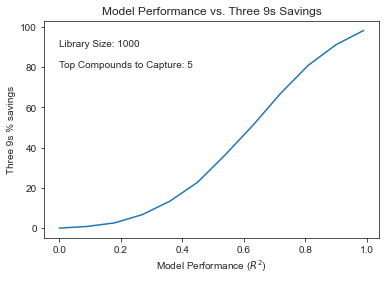

In [220]:
plot_performance_vs_savings(r2_range, savings, nines ="Three", lib_size=1000, ex_capture=5, savefig=False)

As a rule of thumb—following an example set by Martin et al. (2019)—we try to achieve an $R^2$ ≥ .3 benchmarked on a 10-fold cross-validated scaffold-split before hosting a given model on the free version of the OpenBench Lab. Admittedly, a couple of our under construction CYP inhibtion models don’t currently meet that standard. Nonetheless, it seems appropriate that the .3 threshold corresponds to about 10% “three 9s” savings in the scenario above, offering reasonable utility out-of-the-box. To improve on what’s available out-of-the-box, we encourage organizations to leverage their in-house data using the OpenBench platform. The more high quality data that is incorporated into the model training, the better the models tend to perform on predictive tasks.

## The larger the screening library, the more “n 9s” savings potential

In [211]:
def chart_libsize_vs_savings(ex_capture, r2, n=3, points=25):
    """
    Simulate n 9s savings across a range of library sizes from 1 to 10,000.
    :int ex_capture: The number of experimental values to capture
    :num r2: The R^2 performance of the model of interest
    :int n: The number of 9's to model performance for
    :int points: The number of points to supply to the plot
    """
    
    log_range = [int(x) for x in list(np.logspace(0, 4, points))]
    
    n_9s_savings_list = []
    for lib in tqdm(log_range):
        n_9s_savings_list.append(n_9s_performance(ex_capture, lib, r2, n=n, percent=True, verbose=False))
        
    return log_range, n_9s_savings_list

In [296]:
def plot_libsize_vs_savings(x, y, nines = "Three", r2=.46, ex_capture=1, savefig=True):
    """
    Plots library size vs savings
    :list-like x: Values to plot on the x-axis
    :list-like y: Values to plot on the y-axis
    :str nines: Number of nines to cite in the plot labels
    :num r2: model performance R^2
    :int ex_capture: metadata for saving figure
    :bool savefig: if True, save the figure as a png
    """

    xnew = np.logspace(0, 4, int(len(x)/2))
    
    f = interp1d(x, y)
    
    ynew = f(xnew)
    
    sns.set_style("ticks")
    fig, ax = plt.subplots() 
    plt.xscale('log')
    plt.plot(xnew, ynew)
    plt.xlabel('log Screening Library Size')
    plt.ylabel('{} 9s % savings'.format(nines))
    plt.title('log Library Size vs. {} 9s Savings'.format(nines))
    ax.annotate('Model $R^2$: {}\n\nTop Compounds to Capture: {}'.format(r2, ex_capture), xy = (2, 50))
    plt.show()
    
    if savefig:
        fig.savefig('{} 9s vs. libsize_r2-{}_capt-{}.png' \
                        .format(nines, r2, ex_capture), bbox_inches='tight')

Here we see “three 9s” savings plotted against library size for a range of examples from a one compound library to a 10,000 compound library. As the library grows, the model is able to have more and more impact on the challenge of picking out the top compound. In this chart, we use the $R^2$ from the HLM example (.46) and reduce the # of compounds to capture to 1 to make sense of the library size range at every step.

In [281]:
lib_size_range, lib_savings = chart_libsize_vs_savings(1, r2=.46, points=25)

/Users/jamesyoder/opt/anaconda3/envs/opnbnchmark/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


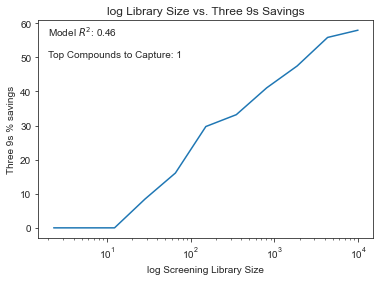

In [282]:
plot_libsize_vs_savings(lib_size_range, lib_savings)

You’ll note that “three 9s” savings is 0% on libraries smaller than ~20 compounds, which obviates many natural use cases for _in silico_ tools, especially in lead optimization settings. A higher quality model would be necessary to make a safe curation impact in such a small library setting. On the other hand, nearly half of a 1,000 compound library could be excluded while retaining 99.9% confidence that the top compound is among those kept, even with modest model performance. Virtual high-throughput screens seem to carry more promise than lead optimization use cases with current tools.

## The larger the top n subset we want to capture, the more it will cost

In [292]:
def capture_vs_savings(lib_size, r2, n=3, points=25):
    """
    Simulate n 9s savings across a range of experimental capture preferences
    :int lib_size: The number of compounds in your library
    :num r2: The R^2 performance of the model of interest
    :int n: The number of 9's to model performance for
    :int points: The number of points to supply to the plot
    """
    
    capture_n = [int(x) for x in list(np.linspace(1, 500, points))]
    
    n_9s_savings_list = []
    for capture in capture_n:
        n_9s_savings_list.append(n_9s_performance(capture, lib_size=lib_size, r2=r2, n=n, verbose=False))
        
    return capture_n, n_9s_savings_list

In [300]:
def plot_capture_vs_savings(x, y, nines = "Three", r2=.46, lib_size=10000, savefig=True):
    """
    Plots savings vs. capture preference
    :list-like x: Values to plot on the x-axis
    :list-like y: Values to plot on the y-axis
    :str nines: Number of nines to cite in the plot labels
    :num r2: model performance R^2
    :int lib_size: Size of library
    :bool savefig: if True, save the figure as a png
    """
    
    xnew = np.linspace(1, 500, 20)
    
    f = interp1d(x, y)
    
    ynew = f(xnew)
    
    sns.set_style("ticks")
    fig, ax = plt.subplots() 
#     plt.xscale('log')
    plt.plot(xnew, ynew)
    plt.xlabel('Top captured out of 10000')
    plt.ylabel('{} 9s % savings'.format(nines))
    plt.title('Capture out of 10000 vs. {} 9s Savings'.format(nines))
    ax.annotate('Model $R^2$: {}\n\nLibrary Size: {}'.format(r2, lib_size), xy = (300, 30))
    plt.show()
    
    if savefig:
        fig.savefig('{} 9s vs. capture_r2-{}_lib-{}.png' \
                        .format(nines, r2, lib_size), bbox_inches='tight')
    

Holding model performance constant, it is much more difficult to capture the top 100 of compounds from a library than it is to capture the top 10. In general, savings drop off substantially the more top compounds we want to capture with “n 9s” certainty. Thankfully, for most drug discovery use cases, capturing a select, small subset of top compounds is precisely the goal.

In [302]:
n, top_n_savings=  capture_vs_savings(lib_size=1000, points=50, r2=.46)

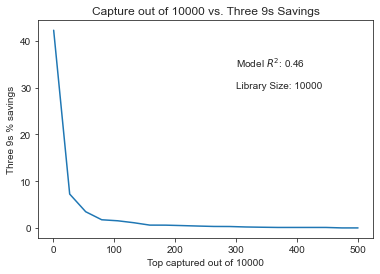

In [301]:
plot_capture_vs_savings(n, top_n_savings)